# NBM QPF Stats for Fire Polygons
#### Regionmask example for selection of data from shapefile/polygons
Notebook built as standalone directory but just update paths to apply elsewhere

In [1]:
import sys
import regionmask

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

from glob import glob

# Silences 'stat of all NaN slice'
import warnings
warnings.filterwarnings('ignore')

#### <u>Collect the shapefiles and open them in GeoPandas</u>

In [2]:
# Wildcard search shapefiles with glob
# could pass other arguments to limit results

shapefiles = sorted(glob('./shp/*.shp'))
shapefiles

['./shp/badgercreek_2018_wy_10mi_buffer.shp',
 './shp/bighorn_2020_az_10mi_buffer.shp',
 './shp/boot_2018_ca_10mi_buffer.shp',
 './shp/briceburg_2019_ca_10mi_buffer.shp',
 './shp/bridgerfoothills_2020_mt_10mi_buffer.shp',
 './shp/broad_2018_nv_10mi_buffer.shp',
 './shp/bulldraw_2018_co_10mi_buffer.shp',
 './shp/burro_2018_co_10mi_buffer.shp']

In [3]:
# Read each file into a geopandas dataset using list comprehension
# Then concatenate that list into a single Pandas DataFrame
polygons = pd.concat([gpd.read_file(file) for file in shapefiles])

# Reindex the polygons with unique ids
polygons = polygons.reset_index().drop(columns=['index', 'Id'])

#### xarray will read the model data into a lat lon projection (WGS84/EPSG:4326, I believe is used)
**** Need to double check in xarray docs! ****<br>

As a result, we need to match our shapefile to this projection

In [4]:
polygons.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# Reproject from 3857 to 4326
polygons = polygons.to_crs('epsg:4326')
polygons

,Name,State,Year,Center_Lat,Center_Lon,geometry
0,Badger Creek,WY,2018,41.04381,-106.10203,"POLYGON ((-106.00707 40.86878, -106.00723 40.8..."
1,Bighorn,AZ,2020,32.43729,-110.75432,"POLYGON ((-110.74703 32.71405, -110.74694 32.7..."
2,Boot,CA,2018,38.38496,-119.42956,"POLYGON ((-119.34248 38.21953, -119.34286 38.2..."
3,Briceburg,CA,2019,37.60390,-119.93276,"POLYGON ((-119.94629 37.43594, -119.94639 37.4..."
4,Bridger Foothills,MT,2020,45.73735,-110.91915,"POLYGON ((-110.92226 45.55870, -110.92271 45.5..."
5,Broad,NV,2018,38.74620,-117.21963,"POLYGON ((-117.21625 38.59383, -117.21666 38.5..."
6,Bull Draw,CO,2018,38.50113,-108.66104,"POLYGON ((-108.67979 38.74329, -108.67821 38.7..."
7,Burro,CO,2018,37.51485,-108.09099,"POLYGON ((-108.11852 37.68835, -108.11832 37.6..."


#### <u>Collect the NBM grib data</u>
glob wildcard/regex search can be modified to isolate one model run at a time

In [6]:
# The easiest way to do this is to pass the init time you care about
# as a sys.argv[n] command line input, then use it in the glob search
# searching for a directory works this way too

# init_str = sys.argv[1]

gribfiles = glob('./grib/*.grib2')
gribfiles

['./grib/hrrr.t12z.wrfsfcf01.grib2', './grib/hrrr.t12z.wrfsfcf02.grib2']

There are ways to speed up the multi-file i/o here but
if only reading one model run at a time, not entirely necessary

In [7]:
gribdata = []
for gribfile in gribfiles:
    gribdata.append(xr.open_dataset(gribfile, 
                    engine='cfgrib', 
                    backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface'}})
                    #[['prate', 'tp']] #if subsetting variables, do here before xr.concat
                   ) 
    
gribdata = xr.concat(gribdata, dim='valid_time')

# Convert mm to in
# Can repeat for prate or other variables too
gribdata['tp'] /= 25.4
gribdata = gribdata.rename({'tp':'tp_in'})

gribdata

<xarray.Dataset>
Dimensions:     (valid_time: 2, x: 1799, y: 1059)
Coordinates:
    time        datetime64[ns] 2020-12-20T12:00:00
    step        (valid_time) timedelta64[ns] 01:00:00 02:00:00
    surface     int64 0
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
  * valid_time  (valid_time) datetime64[ns] 2020-12-20T13:00:00 2020-12-20T14...
Dimensions without coordinates: x, y
Data variables:
    gust        (valid_time, y, x) float32 7.858349 7.920849 ... 6.3058386
    t           (valid_time, y, x) float32 295.8172 295.8172 ... 275.14618
    prate       (valid_time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tp_in       (valid_time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-12-23T11:15:44 GRIB to CDM+CF via cfgrib-0....

## <u>Create bool mask from polygons</u>
#### The bulk of the mask magic

In [8]:
# Pull the lat, lon from the file
y = lat = gribdata.latitude
x = lon = gribdata.longitude

# Select the metadata column to group by (see above dataframe)
meta_column = 'Name'

# I prefer to select the column to mask by manually, so I'm passing [meta_column, 'geometry']
# We need to pass lon, lat from the model grid that we are masking
# drop=False keeps each polygon as it's own mask
# wrap_lon=True accounts for the 0-360 based model data vs -180-180 polygons
# (can also use wrap_lon=None and subtract 360 from gribdata above)
mask = regionmask.mask_3D_geopandas(polygons[[meta_column, 'geometry']],
                                    lon, lat, 
                                    drop=False, wrap_lon=True)

# Since the metadata gets dropped in masking, fix here
mask['region'] = polygons[meta_column].values.astype(str)
mask = mask.rename({'region':meta_column.lower()})

mask

<xarray.DataArray (name: 8, y: 1059, x: 1799)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    lat      (y, x) float64 21.14 21.15 21.15 21.16 ... 47.87 47.86 47.85 47.84
    lon      (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.0 299.1
  * name     (name) <U17 'Badger Creek' 'Bighorn' 'Boot' ... 'Bull Draw' 'Burro'

In [9]:
# Broadcast the mask and grib dimensions against each other
# While we can work around this in differnet ways, this is 
# about the most convenient
gribdata, mask = xr.broadcast(gribdata, mask)
gribdata_masked = xr.where(mask, gribdata, np.nan)

# We can calculate stats over multiple variables if we want, 
# just do the following for the entire DataArray,
# but for just isolate 'tp'
tp_masked = gribdata_masked['tp_in']
tp_masked

<xarray.DataArray 'tp_in' (valid_time: 2, x: 1799, y: 1059, name: 8)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * y           (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
  * x           (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    lat         (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    lon         (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
  * name        (name) <U17 'Badger Creek' 'Bighorn' ... 'Bull Draw' 'Burro'
  * valid_time  (valid_time) datetime64[ns] 2020-12-20T13:00:00 2020-12-20T14...
    surface     int64 0
    time        datetime64[ns] 2020-12-20T12:00:00
    step        (valid_time) timedelta64[ns] 01:00:00 02:00:00
    longitude   (y, x) float64 237.3 237.3 237.3 237.4 ... 299.0 299.0 299.1
    latitude    (y, x) float64 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84

#### <u>Calculate the basic stats here</u>
Xarray offers a number of others if desired that are grid optimized like these (stdev, kurt, skew, etc...)<br>
Other stat calculations can be manually fed through a custom ufunc<br>

In [10]:
tp_stats = xr.merge(
    [tp_masked.max(dim=['valid_time', 'x', 'y']).rename('tp_max'),
    tp_masked.min(dim=['valid_time', 'x', 'y']).rename('tp_min'),
    tp_masked.mean(dim=['valid_time', 'x', 'y']).rename('tp_mean')])

tp_stats

<xarray.Dataset>
Dimensions:  (name: 8)
Coordinates:
  * name     (name) <U17 'Badger Creek' 'Bighorn' 'Boot' ... 'Bull Draw' 'Burro'
    surface  int64 0
    time     datetime64[ns] 2020-12-20T12:00:00
Data variables:
    tp_max   (name) float32 0.0 0.0 0.0 0.0 0.00011811024 0.0 0.0 0.0
    tp_min   (name) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    tp_mean  (name) float32 0.0 0.0 0.0 0.0 3.3270494e-06 0.0 0.0 0.0

#### <u>Visualizing the data: Example</u>

In [11]:
polygon_stats = polygons.copy()

# Insert at position 5, before 'geometry' - but could insert anywhere
polygon_stats.insert(5, 'max_qpf', tp_stats['tp_max'].values)
polygon_stats.insert(5, 'min_qpf', tp_stats['tp_min'].values)
polygon_stats.insert(5, 'mean_qpf', tp_stats['tp_mean'].values)

# Can add the init time here, valid time, whatever else you need to save out
# This can be done as either column data or DataFrame attributes

polygon_stats

,Name,State,Year,Center_Lat,Center_Lon,mean_qpf,min_qpf,max_qpf,geometry
0,Badger Creek,WY,2018,41.04381,-106.10203,0.000000,0.0,0.000000,"POLYGON ((-106.00707 40.86878, -106.00723 40.8..."
1,Bighorn,AZ,2020,32.43729,-110.75432,0.000000,0.0,0.000000,"POLYGON ((-110.74703 32.71405, -110.74694 32.7..."
2,Boot,CA,2018,38.38496,-119.42956,0.000000,0.0,0.000000,"POLYGON ((-119.34248 38.21953, -119.34286 38.2..."
3,Briceburg,CA,2019,37.60390,-119.93276,0.000000,0.0,0.000000,"POLYGON ((-119.94629 37.43594, -119.94639 37.4..."
4,Bridger Foothills,MT,2020,45.73735,-110.91915,0.000003,0.0,0.000118,"POLYGON ((-110.92226 45.55870, -110.92271 45.5..."
5,Broad,NV,2018,38.74620,-117.21963,0.000000,0.0,0.000000,"POLYGON ((-117.21625 38.59383, -117.21666 38.5..."
6,Bull Draw,CO,2018,38.50113,-108.66104,0.000000,0.0,0.000000,"POLYGON ((-108.67979 38.74329, -108.67821 38.7..."
7,Burro,CO,2018,37.51485,-108.09099,0.000000,0.0,0.000000,"POLYGON ((-108.11852 37.68835, -108.11832 37.6..."


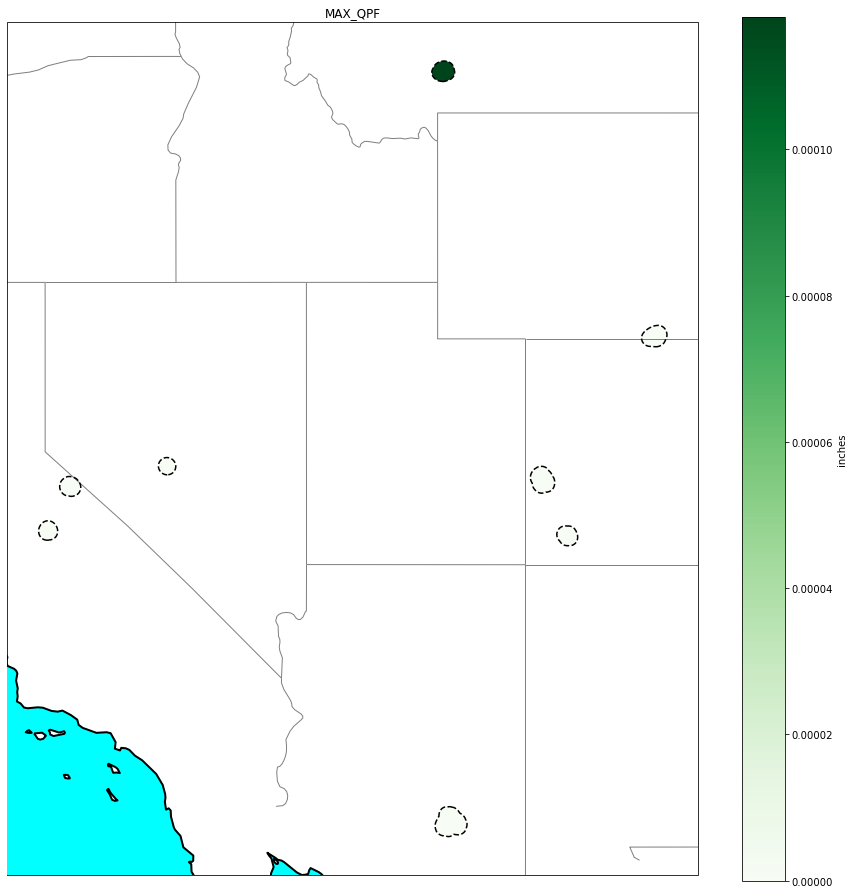

In [12]:


fig = plt.figure(figsize=(12, 12), facecolor='w')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Plot the geog data like states, coastlines...
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='cyan', edgecolor=None)
ax.coastlines(linewidth=2, zorder=101)

# Choose which column values to plot
plot_column = 'max_qpf'
ax.set_title(plot_column.upper())

# Plot the shapefile outlines
polygon_stats.geometry.boundary.plot(color=None, edgecolor='black', linestyle='--', linewidth=1.5, ax=ax)

# Color fill the data values
polygon_stats.plot(column=plot_column, ax=ax, cmap='Greens', legend=True, legend_kwds={'label': "inches"})

#### <u>Output the data here:</u>
Can modify the JSON output however you want,<br>
could manually create the dict from the Dataset,<br>
but xArray offers a quick option:<br>
<br>
Adding attributes or coordinates to the xarray Dataset before .to_dict()<br>
will help populate the json with things like init time, valid times, etc.<br>

In [13]:
tp_json = tp_stats.to_dict()
tp_json

{'coords': {'name': {'dims': ('name',),
   'attrs': {},
   'data': ['Badger Creek',
    'Bighorn',
    'Boot',
    'Briceburg',
    'Bridger Foothills',
    'Broad',
    'Bull Draw',
    'Burro']},
  'surface': {'dims': (),
   'attrs': {'long_name': 'original GRIB coordinate for key: level(surface)',
    'units': '1'},
   'data': 0},
  'time': {'dims': (),
   'attrs': {'long_name': 'initial time of forecast',
    'standard_name': 'forecast_reference_time'},
   'data': datetime.datetime(2020, 12, 20, 12, 0)}},
 'attrs': {},
 'dims': {'name': 8},
 'data_vars': {'tp_max': {'dims': ('name',),
   'attrs': {},
   'data': [0.0, 0.0, 0.0, 0.0, 0.00011811024160124362, 0.0, 0.0, 0.0]},
  'tp_min': {'dims': ('name',),
   'attrs': {},
   'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
  'tp_mean': {'dims': ('name',),
   'attrs': {},
   'data': [0.0, 0.0, 0.0, 0.0, 3.327049398649251e-06, 0.0, 0.0, 0.0]}}}

<br>There's also some options to output geojson - the easiest way to do this would<br>
be to put the data back into a copy of the polygons geoDataFrame as columns<br>
indexed by time or some other monotonic value, but you can take the output from here<br>

That would also be the easiest way to re-project the data back to a different projection<br>
for web - all you need to do is .to_crs('epsg:####')<br>

In [14]:
# You can change the output epsg here if desired... just an example
polygon_stats.to_crs('epsg:3857').to_file("firestats.geojson", driver='GeoJSON')

#### Any questions on how to do so, just let me know and I'll see if I can guide!<br>